<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/EfficientNetKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pillow

In [ ]:
!pip install cloud_tpu_client

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow import keras
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights=None)
import PIL.Image
import pathlib


In [5]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [6]:
batch_size = 4
IMG_SIZE = 240
original_dataset_dir = 'drive/MyDrive/mri_images/train'

In [7]:
data_dir = pathlib.Path(original_dataset_dir)

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 510 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)


['0', '1', '2']


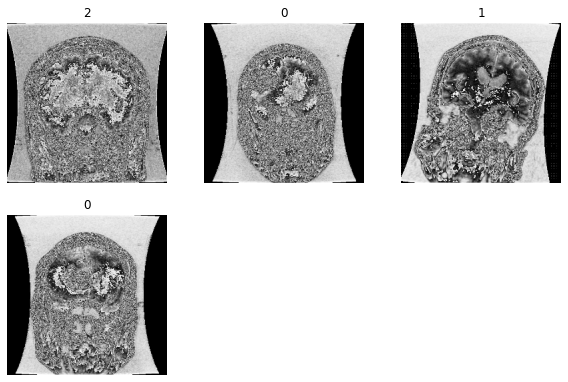

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 240, 240, 3)
(4,)


In [19]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

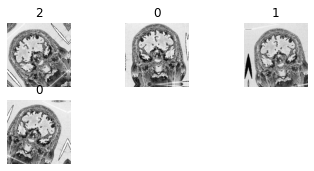

In [20]:
for image, label in train_ds.take(1):
    for i in range(4):
        aug_img = img_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [21]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None), name='img_augmentation/random_contrast/adjust_contrast/Identity:0', description="created by layer 'img_augmentation'")
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then br

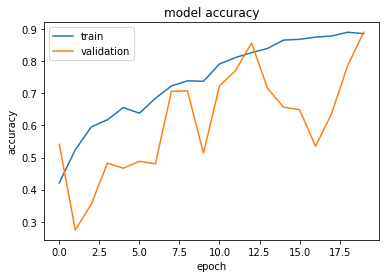

In [22]:
with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    print(inputs)
    x = img_augmentation(inputs)
    print(x)
    outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 20  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

In [23]:
img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 2 with a 56.49 percent confidence.


In [24]:
from tensorflow.keras.layers.experimental import preprocessing

In [25]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


27025408/27018416 [==============================] - 0s 0us/step
Epoch 1/20
511/511 - 37s - loss: 2.0223 - accuracy: 0.7238 - val_loss: 1.9225 - val_accuracy: 0.7863
Epoch 2/20
511/511 - 24s - loss: 2.0352 - accuracy: 0.7742 - val_loss: 2.3459 - val_accuracy: 0.7686
Epoch 3/20
511/511 - 22s - loss: 1.9247 - accuracy: 0.7649 - val_loss: 2.1217 - val_accuracy: 0.7529
Epoch 4/20
511/511 - 23s - loss: 1.7631 - accuracy: 0.7870 - val_loss: 1.7139 - val_accuracy: 0.8059
Epoch 5/20
511/511 - 24s - loss: 1.6191 - accuracy: 0.7865 - val_loss: 0.8163 - val_accuracy: 0.8588
Epoch 6/20
511/511 - 23s - loss: 1.2898 - accuracy: 0.7850 - val_loss: 0.8938 - val_accuracy: 0.7863
Epoch 7/20
511/511 - 20s - loss: 1.2217 - accuracy: 0.7644 - val_loss: 0.6183 - val_accuracy: 0.8667
Epoch 8/20
511/511 - 22s - loss: 0.9207 - accuracy: 0.7894 - val_loss: 0.5231 - val_accuracy: 0.8569
Epoch 9/20
511/511 - 22s - loss: 0.8110 - accuracy: 0.7850 - val_loss: 0.7329 - val_accuracy: 0.7922
Epoch 10/20
511/511 - 22s 

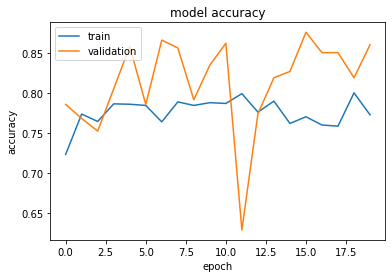

This image most likely belongs to 0 with a 42.83 percent confidence.


In [26]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

    epochs = 20  # @param {type: "slider", min:8, max:80}
    hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

model.summary()

plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
) 

In [ ]:
model.summary()

Epoch 1/20
511/511 - 35s - loss: 0.5597 - accuracy: 0.8217 - val_loss: 0.3233 - val_accuracy: 0.8863
Epoch 2/20
511/511 - 23s - loss: 0.4675 - accuracy: 0.8389 - val_loss: 0.2873 - val_accuracy: 0.9098
Epoch 3/20
511/511 - 23s - loss: 0.4747 - accuracy: 0.8374 - val_loss: 0.2457 - val_accuracy: 0.9235
Epoch 4/20
511/511 - 21s - loss: 0.4613 - accuracy: 0.8428 - val_loss: 0.2891 - val_accuracy: 0.9020
Epoch 5/20
511/511 - 22s - loss: 0.3968 - accuracy: 0.8570 - val_loss: 0.2431 - val_accuracy: 0.9137
Epoch 6/20
511/511 - 23s - loss: 0.3911 - accuracy: 0.8658 - val_loss: 0.2897 - val_accuracy: 0.8980
Epoch 7/20
511/511 - 23s - loss: 0.3883 - accuracy: 0.8604 - val_loss: 0.2949 - val_accuracy: 0.9059
Epoch 8/20
511/511 - 22s - loss: 0.3304 - accuracy: 0.8805 - val_loss: 0.2263 - val_accuracy: 0.9275
Epoch 9/20
511/511 - 23s - loss: 0.3830 - accuracy: 0.8663 - val_loss: 0.2556 - val_accuracy: 0.9078
Epoch 10/20
511/511 - 23s - loss: 0.3606 - accuracy: 0.8756 - val_loss: 0.2486 - val_accura

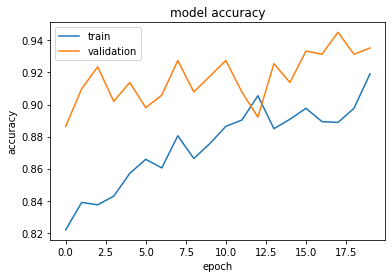

This image most likely belongs to 0 with a 45.77 percent confidence.


In [27]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 20  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)



In [ ]:
model.summary()